In [ ]:
# install PySpark
!pip install pyspark

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import (
    col, collect_list, udf, expr, lit, when,
    abs as spark_abs, sum as spark_sum
)
from pyspark.sql.types import (
    StructType, StructField, IntegerType, StringType, FloatType
)
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql.window import Window
import pyspark.sql.functions as F

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Init step

In [ ]:
# initialize SparkSession
spark = SparkSession.builder.appName("CollaborativeFilteringOptimized").getOrCreate()

In [ ]:
# Define the path to the CSV file
file_path = "/content/ratings2k.csv"

# Define the schema for the DataFrame
schema_def = StructType([
    StructField("index", IntegerType(), True),
    StructField("user", IntegerType(), True),
    StructField("item", IntegerType(), True),
    StructField("rating", FloatType(), True)
])

# Attempt to read the CSV file
try:
    ratings_df = spark.read.csv(file_path, header=True, schema=schema_def)
    print(f"Successfully initiated data loading from: {file_path}")
except Exception as e:
    print(f"Error reading CSV file: {e}")
    print("Please ensure 'ratings2k.csv' exists at the specified path, has a header, and matches the schema.")
    ratings_df = spark.createDataFrame([], schema_def)
    print("An empty DataFrame has been created due to the loading error.")

# Validate and split data
if ratings_df.count() > 0:
    print("\nInitial data loaded and schema verified:")
    ratings_df.show(5, truncate=False)
    ratings_df.printSchema()

    # --- USER-WISE STRATIFIED SPLIT ---

    # 1. Assign a row number to each rating within each user's group, ordered randomly for splitting.
    # to split chronologically (e.g., older ratings for training, newer for testing).
    user_window_spec = Window.partitionBy("user").orderBy(F.rand(seed=42))
    ratings_with_row_num = ratings_df.withColumn("row_num", F.row_number().over(user_window_spec))

    # 2. Count total ratings per user.
    user_rating_counts = ratings_with_row_num.groupBy("user").agg(F.count("*").alias("total_ratings"))

    # 3. Join total rating counts back to the main DataFrame.
    ratings_with_counts = ratings_with_row_num.join(user_rating_counts, "user", "inner")

    # 4. Determine the number of training samples per user (e.g., 80%).
    # This logic aims to ensure that users with >1 rating have at least one rating in the test set.
    train_proportion = 0.8

    ratings_with_split_point = ratings_with_counts.withColumn(
        "num_train_ratings",
        F.when(col("total_ratings") <= 1, col("total_ratings")) # All ratings go to train if user has only 1 rating
        .otherwise(F.greatest(F.lit(1), F.floor(col("total_ratings") * train_proportion))) # At least 1 for train, ~80%
    )
    # Adjust to ensure at least one test sample if total_ratings > 1 and all were initially assigned to train
    ratings_with_split_point = ratings_with_split_point.withColumn(
        "num_train_ratings_adjusted",
        F.when((col("total_ratings") > 1) & (col("num_train_ratings") == col("total_ratings")), col("num_train_ratings") - 1)
        .otherwise(col("num_train_ratings"))
    )

    # 5. Create training and test sets based on the calculated split point for each user.
    training_df = ratings_with_split_point.filter(col("row_num") <= col("num_train_ratings_adjusted")) \
                                       .drop("row_num", "total_ratings", "num_train_ratings", "num_train_ratings_adjusted")

    test_df = ratings_with_split_point.filter(col("row_num") > col("num_train_ratings_adjusted")) \
                                    .drop("row_num", "total_ratings", "num_train_ratings", "num_train_ratings_adjusted")

    # Optional: Cache DataFrames if they are used frequently later.
    # training_df.cache()
    # test_df.cache()

    print(f"\nData split user-wise (stratified):")
    print(f"Total ratings in training set: {training_df.count()}")
    print(f"Total ratings in test set: {test_df.count()}")

    # Verify user distribution (optional check)
    print("\nUser distribution check in train/test sets:")
    users_in_train_count = training_df.select("user").distinct().count()
    users_in_test_count = test_df.select("user").distinct().count()
    print(f"Number of unique users with ratings in training set: {users_in_train_count}")
    print(f"Number of unique users with ratings in test set: {users_in_test_count}")

    # Display first 5 rows of each set
    print("\nTraining data (first 20 rows):")
    training_df.show(20, truncate=False)

    print("\nTest data (first 20 rows):")
    test_df.show(20, truncate=False)

    # Optional: Unpersist DataFrames after use if cached.
    # training_df.unpersist()
    # test_df.unpersist()

else:
    print("\nDataFrame is empty, cannot proceed with data splitting.")
    # Ensure training_df and test_df are defined as empty DataFrames to prevent downstream errors
    if 'training_df' not in locals() or training_df is None:
        training_df = spark.createDataFrame([], schema_def)
    if 'test_df' not in locals() or test_df is None:
        test_df = spark.createDataFrame([], schema_def)


# Collaborative Filtering

In [ ]:
# implement CF model for user-based recommendation using Pearson similarity

class CollaborativeFilteringModel:
    def __init__(self, N, training_data_df_input):
        # initialize model with training data & calculate user similarities
        self.N = N
        if training_data_df_input is None or training_data_df_input.count() == 0:
            print("WARNING: Training data is empty or invalid during model initialization.")
            self.training_df = spark.createDataFrame(
                [],
                training_data_df_input.schema if training_data_df_input else schema_def
            )
            self.user_similarity_df = spark.createDataFrame(
                [],
                StructType([
                    StructField("user1", IntegerType(), True),
                    StructField("user2", IntegerType(), True),
                    StructField("similarity", FloatType(), True)
                ])
            )
        else:
            self.training_df = training_data_df_input
            self.user_similarity_df = self._calculate_user_similarity()

    @staticmethod
    def _calculate_pearson_similarity_static(ratings1, ratings2, items1, items2):
        # calculate Pearson correlation between two users's ratings
        if not ratings1 or not ratings2 or not items1 or not items2:
            return 0.0

        # create item-to-rating mapping
        map_items1 = {item: rating for item, rating in zip(items1, ratings1)}
        map_items2 = {item: rating for item, rating in zip(items2, ratings2)}
        common_items = set(items1).intersection(set(items2))

        if len(common_items) < 2: return 0.0

        # extract ratings for common items
        common_ratings1 = np.array([map_items1[item] for item
                                    in common_items], dtype=np.float64)
        common_ratings2 = np.array([map_items2[item] for item
                                    in common_items], dtype=np.float64)

        # calculate means, standard deviations
        mean1, mean2 = np.mean(common_ratings1), np.mean(common_ratings2)
        std_dev1, std_dev2 = np.std(common_ratings1), np.std(common_ratings2)

        if std_dev1 == 0.0 or std_dev2 == 0.0:
            return 1.0 if mean1 == mean2 and np.array_equal(common_ratings1, common_ratings2) else 0.0

        # compute Pearson correlation
        numerator = np.sum((common_ratings1 - mean1) * (common_ratings2 - mean2))
        denominator = (
            np.sqrt(np.sum((common_ratings1 - mean1) ** 2)) *
            np.sqrt(np.sum((common_ratings2 - mean2) ** 2))
        )

        if denominator == 0.0: return 0.0 # avoid division by zero

        similarity_value = numerator / denominator
        return (
            float(np.clip(similarity_value, -1.0, 1.0))
            if not np.isnan(similarity_value)
            else 0.0
        )

    def _calculate_user_similarity(self):
        # calculate pairwise user similarities using Pearson correlation
        print("Starting user similarity calculation...")
        if self.training_df.count() == 0:
            print("Training data is empty in _calculate_user_similarity. Cannot proceed.")
            return spark.createDataFrame(
                [],
                StructType([
                    StructField("user1", IntegerType(), True),
                    StructField("user2", IntegerType(), True),
                    StructField("similarity", FloatType(), True)
                ])
            )

        # group user ratings and items
        user_ratings_collected_df = (
            self.training_df.groupBy("user")
            .agg(
                collect_list("item").alias("items"),
                collect_list("rating").alias("ratings")
            )
            .alias("u1")
        )

        if user_ratings_collected_df.count() == 0:
            print("No user data after grouping. Cannot calculate similarity.")
            return spark.createDataFrame(
                [],
                StructType([
                    StructField("user1", IntegerType(), True),
                    StructField("user2", IntegerType(), True),
                    StructField("similarity", FloatType(), True)
                ])
            )

        # cross join create user pairs
        user_pairs_df = (
            user_ratings_collected_df.crossJoin(user_ratings_collected_df.alias("u2"))
            .filter(col("u1.user") < col("u2.user"))
        )

        # similarities
        pearson_udf_static = udf(self._calculate_pearson_similarity_static, FloatType())
        similarity_df = (
            user_pairs_df.withColumn(
                "similarity",
                pearson_udf_static(
                    col("u1.ratings"),
                    col("u2.ratings"),
                    col("u1.items"),
                    col("u2.items")
                )
            )
            .select(
                col("u1.user").alias("user1"),
                col("u2.user").alias("user2"),
                "similarity"
            )
        )
        print("User similarity calculation completed.")
        return similarity_df


    def predict(self,  , num_recommendations):
        # generate recommendations for target user, based on similar users
        print(f"\nStarting prediction for user: {target_user_id}")
        empty_recommendations_schema = StructType([
            StructField("item", IntegerType(), True),
            StructField("predicted_score", FloatType(), True)
        ])

        try: target_user_id = int(target_user_id)
        except ValueError:
            raise ValueError(
                f"target_user_id '{target_user_id}' must be an integer or a string "
                "representation of an integer."
            )

        if self.user_similarity_df is None or self.user_similarity_df.count() == 0:
            print("User similarity data is missing. Cannot predict.")
            return spark.createDataFrame([], empty_recommendations_schema)

        # find similar users
        similar_users_candidates = self.user_similarity_df.filter(
            (col("user1") == target_user_id) | (col("user2") == target_user_id)
        )
        if similar_users_candidates.count() == 0:
            print(f"No similarity pairs found for user {target_user_id}.")
            return spark.createDataFrame([], empty_recommendations_schema)

        similar_users_df = (
            similar_users_candidates
            .withColumn(
                "similar_user",
                expr(f"CASE WHEN user1 = {target_user_id} THEN user2 ELSE user1 END")
            )
            .select("similar_user", "similarity")
            .orderBy(col("similarity").desc())
            .filter(col("similarity") > 0)
            .limit(self.N)
        )
        if similar_users_df.count() == 0:
            print(f"No similar users found (with similarity > 0) for user {target_user_id}.")
            return spark.createDataFrame([], empty_recommendations_schema)

        print(f"Found {similar_users_df.count()} top similar users (similarity > 0).")

        # items rated by target user
        target_user_rated_items_list = [
            row.item for row in self.training_df
            .filter(col("user") == target_user_id)
            .select("item")
            .collect()
            if row and hasattr(row, 'item')
        ]

        # get ratings from similar users
        similar_user_ratings_df = (
            self.training_df.join(
                similar_users_df,
                self.training_df.user == similar_users_df.similar_user
            )
            .select(
                self.training_df.user.alias("similar_reviewer"),
                self.training_df.item,
                self.training_df.rating,
                similar_users_df.similarity
            )
        )

        # remove rated items
        candidate_items_df = similar_user_ratings_df
        if target_user_rated_items_list:
            candidate_items_df = candidate_items_df.filter(
                ~col("item").isin(target_user_rated_items_list)
            )
        if candidate_items_df.count() == 0:
            print(
                f"No new candidate items (not yet rated by target user) to recommend "
                f"for user {target_user_id}."
            )
            return spark.createDataFrame([], empty_recommendations_schema)

        # compute weighted scores for recommendations
        weighted_sum_df = (
            candidate_items_df.groupBy("item")
            .agg(
                (spark_sum(col("rating") * col("similarity")) /
                 spark_sum(spark_abs(col("similarity")))).alias("predicted_score")
            )
        )
        recommendations_df = weighted_sum_df.orderBy(col("predicted_score").desc()) \
                                            .limit(num_recommendations)

        print(f"Recommendations for user {target_user_id}:")
        if recommendations_df.count() > 0: recommendations_df.show()
        else: print("No recommendations generated.")

        return recommendations_df


    # evaluate model using RMSE
    def evaluate(self, test_data_df_input):
        print("\nStarting model evaluation (optimized version)...")
        if test_data_df_input is None or test_data_df_input.count() == 0:
            print("Test data is empty. Cannot evaluate.")
            return float('nan')
        if self.user_similarity_df is None or self.user_similarity_df.count() == 0:
            print("User similarity data is missing. Cannot evaluate.")
            return float('nan')
        if self.training_df is None or self.training_df.count() == 0:
            print("Training data is missing. Cannot evaluate.")
            return float('nan')

        # prepare test data
        test_users_items = test_data_df_input.select(
            col("user").alias("active_user"),
            col("item").alias("target_item_to_predict"),
            col("rating").alias("actual_rating")
        )

        active_users_for_pred = test_users_items.select("active_user").distinct()

        # expand similarity data for active user
        sim_users_expanded = (
            self.user_similarity_df
            .join(
                active_users_for_pred,
                (self.user_similarity_df["user1"] == active_users_for_pred["active_user"]) |
                (self.user_similarity_df["user2"] == active_users_for_pred["active_user"]),
                "inner"
            )
            .withColumn(
                "base_user_for_sim",
                when(col("user1") == col("active_user"), col("user1")).otherwise(col("user2"))
            )
            .withColumn(
                "similar_user_candidate",
                when(col("user1") == col("active_user"), col("user2")).otherwise(col("user1"))
            )
            .select(
                col("base_user_for_sim").alias("active_user"),
                col("similar_user_candidate").alias("similar_user"),
                col("similarity").alias("sim_score")
            )
            .filter(col("sim_score") > 0)
        )

        # top N similar users
        window_spec = Window.partitionBy("active_user").orderBy(F.desc("sim_score"))
        top_n_similar_users = (
            sim_users_expanded
            .withColumn("rank", F.row_number().over(window_spec))
            .filter(col("rank") <= self.N)
            .select("active_user", "similar_user", "sim_score")
        )

        # prepare training ratings
        training_ratings_renamed = self.training_df.select(
            col("user").alias("su_user_id"),
            col("item").alias("su_item_id"),
            col("rating").alias("su_rating_val")
        )

        # generate predictions
        predictions_base = (
            top_n_similar_users.join(
                training_ratings_renamed,
                top_n_similar_users["similar_user"] == training_ratings_renamed["su_user_id"],
                "inner"
            )
            .select(
                top_n_similar_users["active_user"],
                top_n_similar_users["sim_score"],
                training_ratings_renamed["su_item_id"].alias("item_for_prediction"),
                training_ratings_renamed["su_rating_val"].alias("rating_from_similar")
            )
        )

        # compute predicted ratings
        denominator_expr = F.sum(F.abs(col("sim_score")))
        predicted_ratings_all_items = (predictions_base
            .groupBy("active_user", "item_for_prediction")
            .agg(
                (F.sum(col("rating_from_similar") * col("sim_score"))).alias("numerator"),
                denominator_expr.alias("denominator")
            )
            .withColumn(
                "prediction",
                when(col("denominator") != 0,
                     col("numerator") / col("denominator")
                ).otherwise(None)
            )
            .select(
                col("active_user").alias("user"),
                col("item_for_prediction").alias("item"),
                "prediction"
            )
        )

        # join with test data
        test_data_to_join = test_users_items.select(
            col("active_user").alias("user"),
            col("target_item_to_predict").alias("item"),
            col("actual_rating")
        )

        eval_df = test_data_to_join.join(
            predicted_ratings_all_items,
            ["user", "item"],
            "left"
        ).filter(col("prediction").isNotNull())

        if eval_df.count() == 0:
            print("No valid predictions generated for the test set. Cannot calculate RMSE.")
            return float('nan')

        # calculate RMSE
        evaluator = RegressionEvaluator(
            metricName="rmse",
            labelCol="actual_rating",
            predictionCol="prediction"
        )
        rmse = evaluator.evaluate(eval_df)
        print(f"Evaluation completed (optimized version). RMSE: {rmse}")
        return rmse

# Train


--- Initializing model with N = 5 ---
Starting user similarity calculation...
User similarity calculation completed.

--- Recommending for sample user: 2 ---

Starting prediction for user: 2
Found 5 top similar users (similarity > 0).
Recommendations for user 2:
+----+---------------+
|item|predicted_score|
+----+---------------+
| 333|            5.0|
| 462|            5.0|
| 437|            5.0|
| 428|            5.0|
| 444|            4.5|
+----+---------------+


--- Evaluating model with N = 5 (using optimized evaluate function) ---

Starting model evaluation (optimized version)...
Evaluation completed (optimized version). RMSE: 1.126320086959604
RMSE for N=5: 1.126320086959604

--- Starting evaluation process for different N values (using optimized evaluate function) ---

--- Building and evaluating model with N = 2 ---
Starting user similarity calculation...
User similarity calculation completed.

Starting model evaluation (optimized version)...
Evaluation completed (optimized 

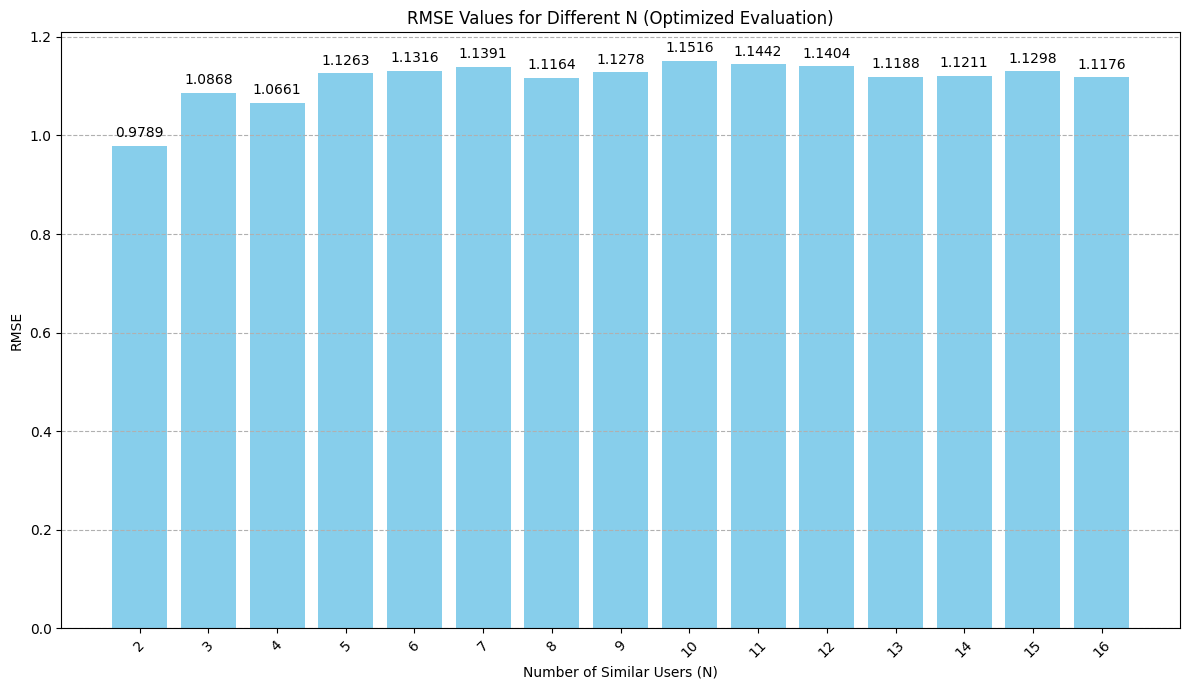

In [ ]:
# train, evaluate, visualize CF model with varying N values

# check valid
if training_df.count() > 0 and test_df.count() > 0:
    N_example = 5
    print(f"\n--- Initializing model with N = {N_example} ---")
    model = CollaborativeFilteringModel(N=N_example, training_data_df_input=training_df)

    # proceed if similarity matrix valid
    if model.user_similarity_df is not None and model.user_similarity_df.count() > 0:
        sample_user_id_val = 2
        print(f"\n--- Recommending for sample user: {sample_user_id_val} ---")
        recommendations = model.predict(
            target_user_id=sample_user_id_val,
            num_recommendations=5
        )

        # evaluate model with N
        print(f"\n--- Evaluating model with N = {N_example} (using optimized evaluate function) ---")
        rmse_example = model.evaluate(test_data_df_input=test_df)
        print(f"RMSE for N={N_example}: {rmse_example}")

        # evaluate model for different N values
        N_values = range(2, 17)
        rmse_results = {}
        print("\n--- Starting evaluation process for different N values (using optimized evaluate function) ---")
        for n_val in N_values:
            print(f"\n--- Building and evaluating model with N = {n_val} ---")
            current_model = CollaborativeFilteringModel(
                N=n_val,
                training_data_df_input=training_df
            )
            if current_model.user_similarity_df is not None and current_model.user_similarity_df.count() > 0:
                current_rmse = current_model.evaluate(test_data_df_input=test_df)
                rmse_results[n_val] = current_rmse
                print(f"Evaluation completed for N = {n_val}, RMSE = {current_rmse}")
            else:
                print(f"Cannot evaluate for N = {n_val} due to error in similarity matrix initialization.")
                rmse_results[n_val] = float('nan')

        # plot RMSE results
        valid_rmse_results = {k: v for k, v in rmse_results.items() if v is not None and not np.isnan(v)}
        if valid_rmse_results:
            n_list_valid = sorted(valid_rmse_results.keys())
            rmse_list_valid = [valid_rmse_results[n] for n in n_list_valid]

            plt.figure(figsize=(12, 7))
            bars = plt.bar([str(n) for n in n_list_valid], rmse_list_valid, color='skyblue')
            plt.xlabel("Number of Similar Users (N)")
            plt.ylabel("RMSE")
            plt.title("RMSE Values for Different N (Optimized Evaluation)")
            plt.xticks(rotation=45)
            plt.grid(axis='y', linestyle='--')

            max_rmse_val = max(rmse_list_valid) if rmse_list_valid else 1
            for bar in bars:
                yval = bar.get_height()
                plt.text(
                    bar.get_x() + bar.get_width() / 2.0,
                    yval + 0.01 * max_rmse_val,
                    f'{yval:.4f}',
                    ha='center',
                    va='bottom'
                )

            plt.tight_layout()
            plt.show()
        else:
            print("No valid RMSE results to plot (after filtering NaN).")
    else:
        print("Error: User similarity matrix could not be created. Cannot proceed with recommendations or evaluation.")
else:
    print("Training or test set is empty. Cannot proceed with training and evaluation.")



In [ ]:
# stop SparkSession
spark.stop()